The purpose of this notebook is to compare our median-VAF-based purity estimates with ones from the other well-established tools. The comparison uses the Cancer Genome Atlas (TCGA) where each method, depending on what data type it uses for the estimation, was run on the same set of patients. Purity estimation tools of interest here are:

 * `ESTIMATE`: gene expression data
 * `ABSOLUTE`: copy-number variation data
 * `LUMP`: methylation data
 * `IHC`: pathology images
 * `CPE`: consensus metric combining others (median value after normalization)

All these estimates are coming from the following study: [Systematic pan-cancer analysis of tumour purity](http://www.nature.com/ncomms/2015/151204/ncomms9971/full/ncomms9971.html). We will be comparing these to our own simplistic metric, called `MPurity`, that we calculate by normalizing the median VAF for a sample by `0.5` (see [first post in the series](0 - What is a variant allele frequency?.ipynb) for details). For this, we will be using the [normalized MAF files from the TCGA project](https://www.biostars.org/p/161298/#161777) that contain VAF information for each of the variants:

In [1]:
!mkdir -p data/downloads \
    && cd data/downloads \
    && wget -c "https://dl.dropboxusercontent.com/u/8680991/mafs/tcga_pancancer_dcc_mafs_082115.tar.gz" \
    && tar zxf "tcga_pancancer_dcc_mafs_082115.tar.gz" \
    && cd ../..

--2016-06-01 00:24:43--  https://dl.dropboxusercontent.com/u/8680991/mafs/tcga_pancancer_dcc_mafs_082115.tar.gz
Resolving dl.dropboxusercontent.com... 45.58.70.37
Connecting to dl.dropboxusercontent.com|45.58.70.37|:443... connected.
HTTP request sent, awaiting response... 206 PARTIAL CONTENT
Length: 354970179 (339M), 0 remaining [text/plain]
Saving to: 'tcga_pancancer_dcc_mafs_082115.tar.gz'

tcga_pancancer_dcc_ 100%[++++++++++++++++++++++] 338.53M  --.-KB/s   in 0s     

2016-06-01 00:24:44 (0.00 B/s) - 'tcga_pancancer_dcc_mafs_082115.tar.gz' saved [354970179/354970179]



Now that we have all the normalized MAF files, let's extract the VAF information from studies that have this information and aggregate these values within a single data-frame:

In [2]:
import glob
import pandas as pd

folder = "data/downloads/mafs" ## Extracted archive folder that contains all the MAFs
df = pd.DataFrame()
for maf_file in glob.glob("{}/*.maf".format(folder)):
    mdf = pd.read_csv(maf_file, delimiter="\t", comment="#", low_memory=False)
    if "t_alt_count" in mdf.columns:  ## Not all MAFs have this. If not, skip the study MAF
        # example file name: `tcga_laml_from_dcc.maf`
        file_name = maf_file.split("/")[-1].split("_")[1].upper()
        # Also corresponds to the study abbreviation
        mdf['Study'] = file_name
        # Shorten the ID to make it compatible with the other data set (see below)
        mdf['Tumor_Sample_Barcode'] = ["-".join(s.split("-")[0:4]) for s in mdf['Tumor_Sample_Barcode']]
        mdf['read_count'] = mdf.t_alt_count + mdf.t_ref_count
        mdf['VAF'] = mdf.t_alt_count / mdf.read_count
        # Only save columns that might be of interest to us
        mdf = mdf[['Study', 'Tumor_Sample_Barcode', 'VAF']]
        df = df.append(mdf)
df.head()

,Study,Tumor_Sample_Barcode,VAF
0,ACC,TCGA-OR-A5J1-01A,0.447761
1,ACC,TCGA-OR-A5J1-01A,0.269231
2,ACC,TCGA-OR-A5J1-01A,0.371134
3,ACC,TCGA-OR-A5J1-01A,0.092593
4,ACC,TCGA-OR-A5J1-01A,0.312500


Our `df` object contains VAF information for all the variants called from the patient data. But we need to summarize this data by taking the median value for each patient and normalizing it against the expected value: `0.5`:

In [3]:
purities = df.groupby(['Study', 'Tumor_Sample_Barcode']).median()
purities['MPurity'] = [min(v, 1) for v in (purities.VAF / 0.5)]  ## min -> safety check for right-skewed data
purities['Study'] = [i[0] for i in purities.index]
purities['Sample'] = [i[1] for i in purities.index]
purities.index = purities.Sample
purities.head()

,VAF,MPurity,Study,Sample
Sample,,,,
TCGA-OR-A5J1-01A,0.333333,0.666667,ACC,TCGA-OR-A5J1-01A
TCGA-OR-A5J2-01A,0.203896,0.407792,ACC,TCGA-OR-A5J2-01A
TCGA-OR-A5J3-01A,0.119048,0.238095,ACC,TCGA-OR-A5J3-01A
TCGA-OR-A5J4-01A,0.246575,0.493151,ACC,TCGA-OR-A5J4-01A
TCGA-OR-A5J5-01A,0.333333,0.666667,ACC,TCGA-OR-A5J5-01A


and if we plot these purity estimated for each study, we get this:

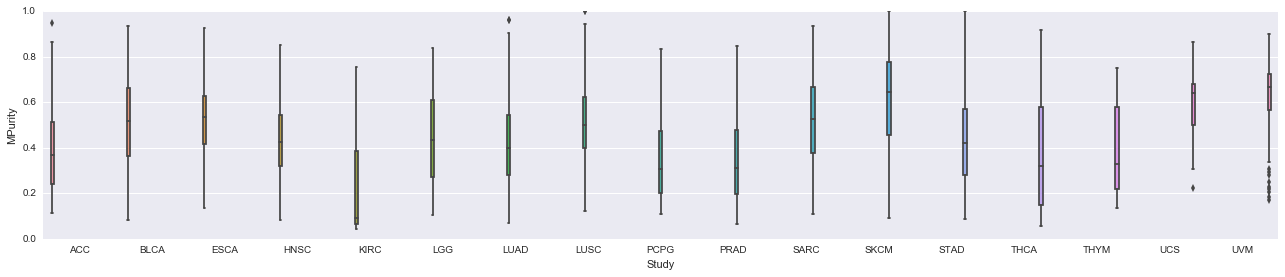

In [4]:
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sns.factorplot(x="Study", y="MPurity", hue="Study", data=purities, kind="box", aspect=4.5)
plt.show()

For comparison, let's load the TCGA estimates from various methods as well:

In [5]:
tcga = pd.read_csv("data/2-ncomms9971_s2.csv")  ## From the supplementary material
tcga.index = tcga["Sample ID"]
tcga.head()

,Sample ID,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE
Sample ID,,,,,,,
TCGA-OR-A5J1-01A,TCGA-OR-A5J1-01A,ACC,0.9368,NaN,0.9774,0.80,0.9246
TCGA-OR-A5J2-01A,TCGA-OR-A5J2-01A,ACC,0.9175,NaN,0.6174,0.95,0.8985
TCGA-OR-A5J3-01A,TCGA-OR-A5J3-01A,ACC,0.9670,NaN,0.9249,0.80,0.9466
TCGA-OR-A5J4-01A,TCGA-OR-A5J4-01A,ACC,NaN,NaN,0.9199,0.80,0.8660
TCGA-OR-A5J5-01A,TCGA-OR-A5J5-01A,ACC,0.9761,NaN,1.0000,0.80,0.9780


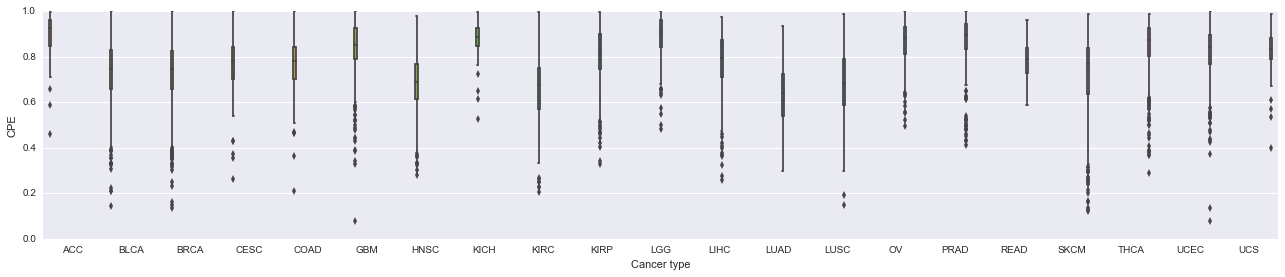

In [6]:
# Plot the consensus purity estimate
sns.factorplot(x="Cancer type", y="CPE", hue="Cancer type", data=tcga, kind="box", aspect=4.5)
plt.show()

The plot above definitely looks somewhat different than ours, but before jumping to any conclusions, let's prepare the data for a fair pairwise-method comparison:

In [7]:
all_ests = pd.concat([tcga.drop(["Sample ID", "Cancer type"], axis=1), purities["MPurity"]], axis=1, join="inner")
# We want to work with complete data, so let's drop the patients that lack at least one of the estimates
all_ests = all_ests.dropna()
all_ests.head()

,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,MPurity
TCGA-BL-A13I-01A,0.5428,0.33,0.4801,0.5024,0.4498,0.328494
TCGA-BL-A13J-01A,0.8793,0.55,0.7816,0.7849,0.7313,0.373480
TCGA-BL-A3JM-01A,0.9193,0.76,0.7276,0.8000,0.8597,0.666667
TCGA-BT-A0S7-01A,0.9097,0.30,0.5578,0.7500,0.6309,0.413903
TCGA-BT-A0YX-01A,0.8479,0.49,0.5182,0.7000,0.7094,0.434783


we can use this data-frame to compare all methods in a pairwise manner:

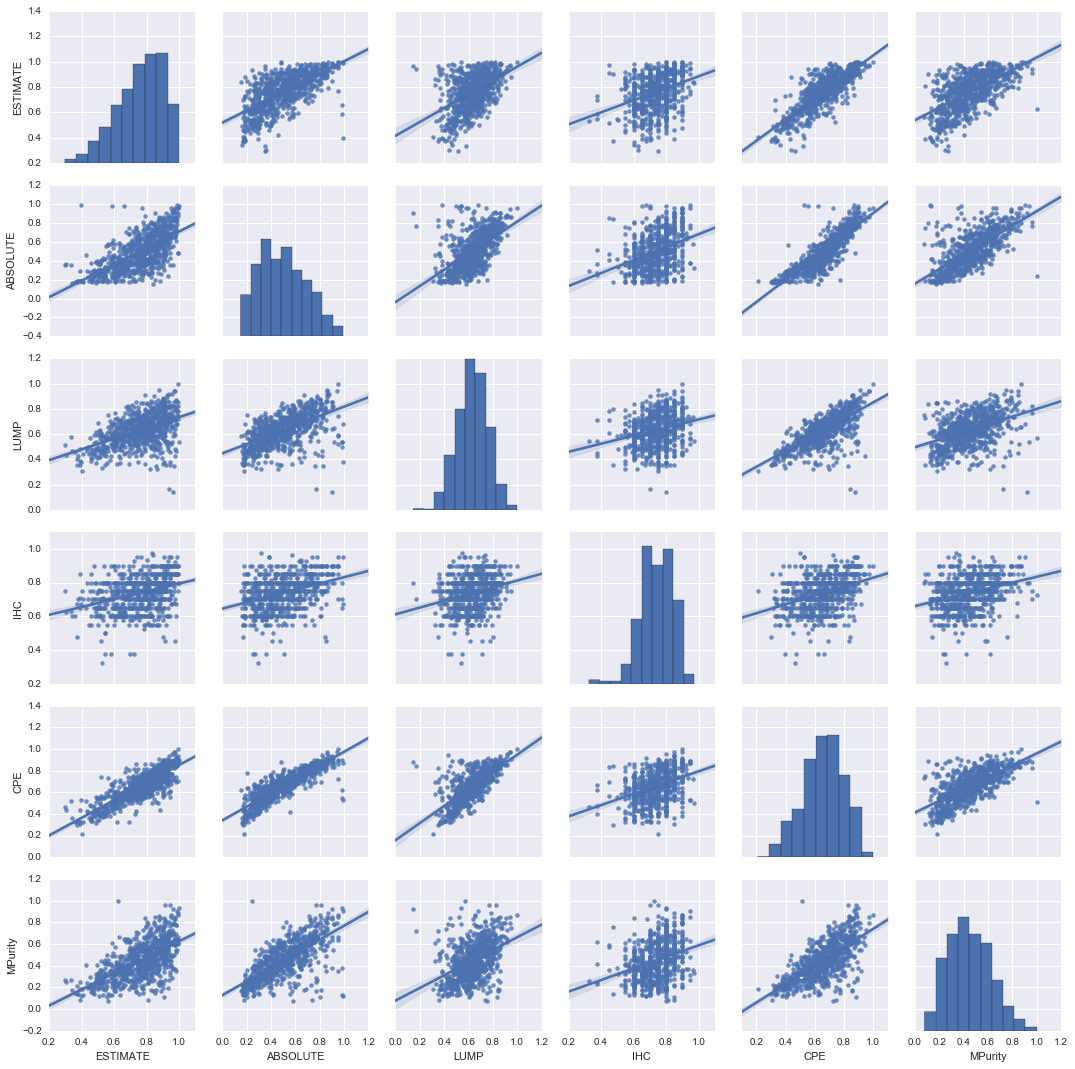

In [8]:
sns.pairplot(all_ests, dropna=True, kind='reg')

Surprising our simplistic `MPurity` estimates are not that bad (see all those correlated metrics), especially considering that we are doing this using a completely different data set than others: mutation data. To get a sense of which methods behave similarly and make estimates that are close to one another, we can calculate the Median Squared Error (MSE) value between two groups of estimates and use this a distance metric to a hierarchical clustering method:

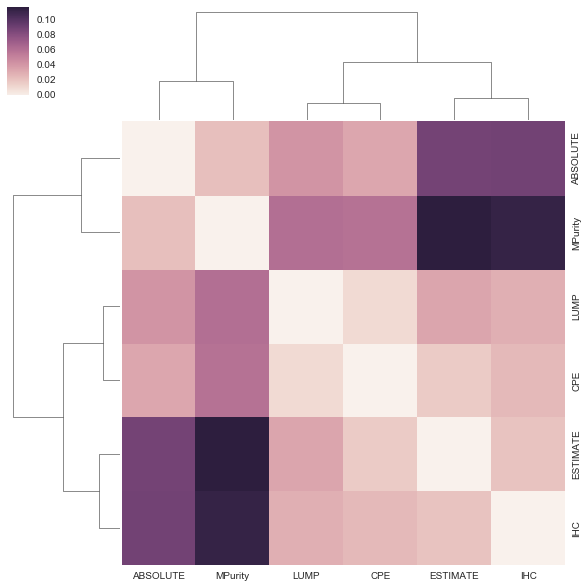

In [9]:
distance = lambda column1, column2: ((column1 - column2) ** 2).mean(axis=None)  ## MSE
mse_matrix = all_ests.apply(lambda col1: all_ests.apply(lambda col2: distance(col1, col2)))
sns.clustermap(mse_matrix)

The cluster-map above shows that `ABSOLUTE` and `MPurity` are closely related metrics (note their dissimilarity with both `IHC` and `ESTIMATE`) and `CPE`, the consensus metric, is moslty dominated by the `LUMP` estimates, which again is not that similar to our own `MPurity`. 

Overall, looks like naive approaches can perform comparably to other established methods. But is there still room for improvement? We will be trying a few other approaches to estimate purity from the mutation data in the following posts as we learn more about the nature of this data set and its relation to the properties of the tumor samples.